In [13]:
import tensorflow as tf
from tensorflow import keras
import time
import numpy as np

latent_dim = 2
train_size = 60000
batch_size = 32
test_size = 10000
epochs = 10
num_examples_to_generate = 16
optimizer = tf.keras.optimizers.Adam(1e-4)

iterative_pruning_percentage = 0.2 # (0, 1) - percentage of weights to prune between each "pruning iteration"
num_pruning_iterations = 25
rewind_weights = 3 # False|epoch number - reverts weights to initial random initialization or specified epoch

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

class CVAE(tf.keras.Model):
  """Fully dense variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            #tf.keras.layers.Conv2D(
            #    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            #tf.keras.layers.Conv2D(
            #    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(784),
            tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
            #tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            #tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            #tf.keras.layers.Conv2DTranspose(
            #    filters=64, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            #tf.keras.layers.Conv2DTranspose(
            #    filters=32, kernel_size=3, strides=2, padding='same',
            #    activation='relu'),
            # No activation
            #tf.keras.layers.Conv2DTranspose(
            #    filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def _log_normal_pdf(self, sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

  def compute_loss(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = self._log_normal_pdf(z, 0., 0.)
    logqz_x = self._log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
  
  @tf.function
  def train_step(self, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
      loss = self.compute_loss(x)
    gradients = tape.gradient(loss, self.trainable_variables)
    optimizer.apply_gradients(zip(gradients, self.trainable_variables))


random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

cvae = CVAE(latent_dim)

(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
            .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
            .shuffle(test_size).batch(batch_size))


In [ ]:
# stats for training loop/plotting
def prune_stats(vae, enc_layers, dec_layers, enc_per_layer_masks, dec_per_layer_masks):
  enc_total = 0
  enc_non_zero = 0
  dec_total = 0
  dec_non_zero = 0
  enc_weights = vae.encoder.get_weights()
  dec_weights = vae.decoder.get_weights()

  for layer in enc_layers:
    enc_weights = vae.encoder.get_weights()
    enc_total += enc_weights[layer].shape[0] * enc_weights[layer].shape[1]
  
  if len(enc_per_layer_masks) != 0:
    enc_non_zero = enc_total
    for i in range(len(enc_layers)):
      enc_non_zero -= enc_per_layer_masks[i].astype(float).sum()

  for layer in dec_layers:
    dec_weights = vae.decoder.get_weights()
    dec_total += dec_weights[layer].shape[0] * dec_weights[layer].shape[1]
  
  if len(dec_per_layer_masks) != 0:
    dec_non_zero = dec_total
    for i in range(len(dec_layers)):
      dec_non_zero -= dec_per_layer_masks[i].astype(float).sum()

  if len(enc_per_layer_masks) == 0:
    print("Encoder | total weights:", enc_total, "non-zero weights:", 100.0, "%.")
    print("Decoder | total weights:", dec_total, "non-zero weights:", 100.0, "%.")
    return 100.0, 100.0

  print("Encoder | total weights:", enc_total, "non-zero weights:", int(enc_non_zero), (enc_non_zero / enc_total) * 100, "%.")
  print("Decoder | total weights:", dec_total, "non-zero weights:", int(dec_non_zero), (dec_non_zero / dec_total) * 100, "%.")
  return round((enc_non_zero / enc_total) * 100, 2), round((dec_non_zero / dec_total) * 100, 2)

# not currently used, identify units that have no connections left in fully dense VAE
def prunable_units(model, layers=[], per_layer_masks=[]):
  weights = model.get_weights()
  num_prunable_weights = 0

  if len(layers) == 0:
    return num_prunable_weights, {}

  prunable_weight_map = {layer: {"map": [], num: 0} for layer in layers}

  for i, layer in enumerate(layers):
    unit_map = np.invert(np.all(weights[layer], axis=0))
    prunable_weight_map[layer]["map"] = unit_map
    total_prunable = unit_map.astype(int).sum()
    prunable_weight_map[layer]["num"] = total_prunable
    num_prunable_weights += total_prunable

  return num_prunable_weights, prunable_weight_map

def store_original_weights(model):
  return model.get_weights()

# creates one-dimensional and per layer pruning masks (easier to handle 1-d during pruning and per layer for faster setting during training loop)
def prune_weights(model, prune_factor, mask=[]):
  weights = model.get_weights()
  edges = {"h" + str(int(0 + (i / 2))): {"edge_count": weights[i].shape[0] * weights[i].shape[1], "shape": (weights[i].shape[0], weights[i].shape[1])} for i in range(2, len(weights) - 2, 2)}
  w = []

  for i in range(2, len(weights) - 2, 2):
    for j in range(weights[i].shape[0]):
      w += weights[i][j].tolist()

  global_weights = np.array(w)
  global_sorted = np.argsort(np.abs(global_weights))

  to_prune = int(np.floor(prune_factor * (len(global_weights) - np.array(mask).astype(float).sum())))
  i = 0
  pruned = 0
  while True:
    if mask[global_sorted[i]] == True:
      i += 1
      continue

    mask[global_sorted[i]] = True
    pruned += 1
    i += 1

    if pruned == to_prune:
      break

  per_layer_masks = []
  start_index = 0
  end_index = 0
  for i in range(int((len(weights) - 4) / 2)):
    shape = edges["h" + str(int(i + 1))]["shape"]
    shift = shape[0] * shape[1]
    end_index += shift
    per_layer_masks.append((mask[start_index:end_index]).reshape(shape[0], shape[1]))
    start_index += shift
    
  return mask, per_layer_masks

In [12]:
# one-dimensional masks (hard-coded lazy implementation, 2 hidden layers 256 nodes each...)
enc_mask = np.zeros(256**2*2)
dec_mask = np.zeros(256**2*2)
enc_mask = enc_mask.astype(bool)
dec_mask = dec_mask.astype(bool)
# history for re-initialize/rewind weights and masks
original_weights = {"encoder": [], "decoder": []}
mask_cache = {"encoder": [], "decoder": []}
mask_per_layer_cache = {"encoder": [], "decoder": []}
# again hard coded as 2 hidden layers
prunable_encoder_layers = 2
prunable_decoder_layers = 2
# placeholder just to hold per layer masks for each pruning iteration
enc_per_layer_masks = []
dec_per_layer_masks = []
# history for plotting
elbo_cache = [[] for i in range(num_pruning_iterations)]
pruned_weights_cache = []

for pruning_iteration in range(num_pruning_iterations):
  original_weights["encoder"].append(store_original_weights(cvae.encoder))
  original_weights["decoder"].append(store_original_weights(cvae.decoder))

  for epoch in range(1, epochs + 1):
    start_time = time.time()

    for train_x in train_dataset:
        cvae.train_step(train_x, optimizer)
        
        if pruning_iteration != 0:
          enc_weights = cvae.encoder.get_weights()
          dec_weights = cvae.decoder.get_weights()
          
          # indexing below (and at end of loop) assumes tensorflow internal representation is always same is of same structure, i.e. weight, bias, weight, bias and that we want to skip input layer
          for i in range(prunable_encoder_layers): 
            enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

          for i in range(prunable_decoder_layers): 
            dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0
          
          cvae.encoder.set_weights(enc_weights)
          cvae.decoder.set_weights(dec_weights)

    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(cvae.compute_loss(test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))
    elbo_cache[pruning_iteration].append(elbo)
    if type(rewind_weights) is int and epoch == rewind_weights:
      original_weights["encoder"] = original_weights["encoder"][:-1]
      original_weights["decoder"] = original_weights["decoder"][:-1]
      original_weights["encoder"].append(store_original_weights(cvae.encoder))
      original_weights["decoder"].append(store_original_weights(cvae.decoder))

  print("Pruning iteration", (pruning_iteration + 1), "/", num_pruning_iterations)
  # hard coded again, know indexes of hidden layers are 2, 4
  enc_prune, dec_prune = prune_stats(cvae, [2, 4], [2, 4], enc_per_layer_masks, dec_per_layer_masks)
  pruned_weights_cache.append((enc_prune, dec_prune))

  enc_mask, enc_per_layer_masks = prune_weights(cvae.encoder, iterative_pruning_percentage, enc_mask)
  mask_cache["encoder"].append(enc_mask)
  mask_per_layer_cache["encoder"].append(enc_per_layer_masks)
  dec_mask, dec_per_layer_masks = prune_weights(cvae.decoder, iterative_pruning_percentage, dec_mask)
  mask_cache["decoder"].append(dec_mask)
  mask_per_layer_cache["decoder"].append(dec_per_layer_masks)
  cvae.encoder.set_weights(original_weights["encoder"][-1])
  cvae.decoder.set_weights(original_weights["decoder"][-1])
  for i in range(prunable_encoder_layers):
    enc_weights = cvae.encoder.get_weights()
    enc_weights[i + 2 + i * 1][enc_per_layer_masks[i]] = 0.0

  for i in range(prunable_decoder_layers):
    dec_weights = cvae.decoder.get_weights()
    dec_weights[i + 2 + i * 1][dec_per_layer_masks[i]] = 0.0

  cvae.encoder.set_weights(enc_weights)
  cvae.decoder.set_weights(dec_weights)

BEFORE TRAIN 0.0 0.0
Epoch: 1, Test set ELBO: -181.26300048828125, time elapse for current epoch: 21.430744647979736
Epoch: 2, Test set ELBO: -172.7793731689453, time elapse for current epoch: 20.782392740249634
Epoch: 3, Test set ELBO: -170.7410430908203, time elapse for current epoch: 20.819172382354736
Epoch: 4, Test set ELBO: -169.40664672851562, time elapse for current epoch: 20.82560086250305
Epoch: 5, Test set ELBO: -168.11790466308594, time elapse for current epoch: 20.878944635391235
Epoch: 6, Test set ELBO: -167.306884765625, time elapse for current epoch: 20.920922994613647
Epoch: 7, Test set ELBO: -166.88711547851562, time elapse for current epoch: 20.96376895904541
Epoch: 8, Test set ELBO: -166.53921508789062, time elapse for current epoch: 20.954233646392822
Epoch: 9, Test set ELBO: -166.24192810058594, time elapse for current epoch: 20.9282283782959
Epoch: 10, Test set ELBO: -165.92189025878906, time elapse for current epoch: 20.897180318832397
Pruning iteration 1 / 25
E

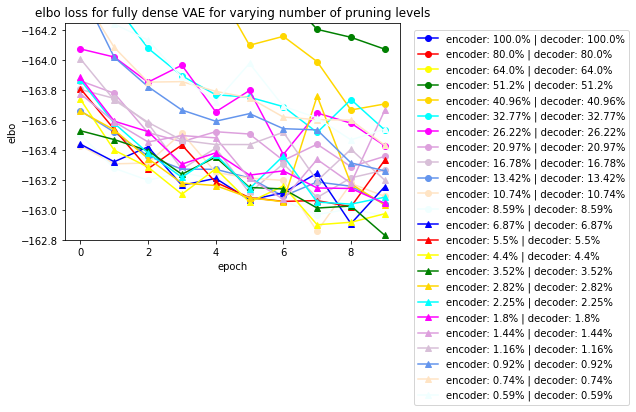

In [35]:
from matplotlib import pyplot as plt

x_all = np.arange(epochs).tolist()
linestyle = "-"
marker = ["o", "^", "p"]
colors = ["blue", "red", "yellow", "green", "gold", "cyan", "fuchsia", "plum", "thistle", "cornflowerblue", "bisque", "azure"]
n_colors = 12
legend = [("encoder: " + str(prune_level[0]) + "% | decoder: " + str(prune_level[1]) + "%") for prune_level in pruned_weights_cache] #["encoder: 100.0% | decoder: 100.0%"]
legend = legend[:-1]
for i in range(num_pruning_iterations - 1):
  plt.plot(x_all, elbo_cache[i], linestyle=linestyle, marker=marker[i // n_colors], color=colors[i - ((i // n_colors) * n_colors)])
  plt.ylim(-162.8, -164.25)
plt.xlabel("epoch")
plt.ylabel("elbo")
plt.title("elbo loss for fully dense VAE for varying number of pruning levels")
plt.legend(legend, bbox_to_anchor = (1.7, 0.99))
plt.show()